# Part 1

## Import Statements

In [1]:
# These are the packages I always input first, because I know I'll use them
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(513)

In [2]:
# Configure my visual settings:
# Let matplotlib visuals show up automatically, without plt.show
%matplotlib inline 

# Change the default parameters for matplotlib:
# Make the default figure size bigger. Especially useful if you'll be presenting 
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
# Set a default style. Fivethirtyeight is a common choice. So is the style from
#  the book "Bayesian Methods for Hackers"
plt.style.use(['bmh'])

In [3]:
# In this slide I'll add additional package import statement as I determine I need them:
import os
from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier


In [4]:
# Now that I've got the preliminaries taken care of, lets import the data.

# What files are we dealing with? Turns out we have a CSV and a text file with bank names.
print(os.listdir())

['.git', '.gitignore', '.ipynb_checkpoints', 'bank-full.csv', 'bank-names.txt', 'DSIR Code Challenge.ipynb', 'README.md', 'Untitled.ipynb']


In [5]:
# Since the CSV we needed is stored in working directory, we don't need to
# provide a path to the file. This won't always be the case!
data = pd.read_csv('bank-full.csv', sep=';')

In [6]:
# We'll use Python's base 'open' function to open the text file and call its 
# 'read' method to store the text of the file.
text_file = open('bank-names.txt').read()

In [7]:
# This is metadata and a data dictionary. Awesome! 
print(text_file)

Citation Request:
  This dataset is public available for research. The details are described in [Moro et al., 2011]. 
  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, GuimarÃ£es, Portugal, October, 2011. EUROSIS.

  Available at: [pdf] http://hdl.handle.net/1822/14838
                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

1. Title: Bank Marketing

2. Sources
   Created by: Paulo Cortez (Univ. Minho) and SÃ©rgio Moro (ISCTE-IUL) @ 2012
   
3. Past Usage:

  The full dataset was described and analyzed in:

  S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European

## Python Coding and Data Set

In [8]:
data.head() 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Always the first call after you've imported data. We might discover we didn't properly capture a header row as column names, Pandas might add an unnecessary index column, or the data might not actually be delimited by a comma. Go back and adjust the `pd.read_csv` function call so that your data looks nice.

In this case, the data is delimited by a semi-colon, rather than a comma.

Exploratory Data Analysis:

Before we visualize or compute descriptive statistics on our data,
we need to make sure the data is being represented to us in the right sorts of ways.
We need to check the data types of the columns, check for encoding errors, Null values, and the like.
We'll want to consult the data dictionary here, and use common sense!

I always like to check for null values first. Pandas's `isnull` function is
great for this, and works on individual columns or the whole dataframe. 
I always sum up the results of the function, which returns
boolean values, to see how many nulls there are. I call the function 
twice: once to sum up all the rows by column, and then to sum up
all the column sums. If that number is zero, I know there are no nulls anywhere:

In [9]:
_ = data.isnull().sum().sum() # Zero nulls! Otherwise I would check nulls by column.

# Spoiler alert: There may be null or N/A values in our dataset that simply aren't 
# encoded as such...

NB: I use explicit square-bracketing (i.e. `df['Series']`) to subset my dataframes because it is
more robust and less likely to confuse than the quicker method of calling columns as dataframe
attribute (i.e. `df.Series`). Choose one way of doing it and stick to it!


NB: Many lines of code return output that you don't care about or don't want to see right now.
I assign the output to an underscore instead of commenting it out, so it is clear that
the code is important and meant to be run! If anything out of the ordinary appears I will
print the output. Otherwise any reader of this notebook should feel free to independently
inspect the output of a line of code.

In [10]:
# Look at the datatypes of every column. Are they strings or numeric?
# If numeric, are they continuous or discrete?
# If categorical, are they binary variables that can be encoded as True/False?
# Are they ordinal in any way?
_ = data.dtypes 

_ = sorted(data['age'].unique()) # Sort all the unique values for the age columns and do an eyeball check.
_ = data['day'].nunique() # 31 unique days. Looks good.

# Lets consider the minimum and maximum values for all of our numeric columns to see if they make sense.
# We can select only the columns that have a data type that is any kind of number, then call 'min' on each column:
_ = data.select_dtypes(include=[np.number]).min()

# It looks like pdays is the number of days that has passed since the customer was contacted, 
# and if the customer was not previously contacted the value is -1. Python is going to interpret
# that like any other number, so we should make some conscious choice about how to represent it:
data['pdays'] = [x if x != -1 else 1000 for x in data['pdays']] # List comprehension.
# See below for why I chose 1,000 here.

# Now we DO have null values, but they're null values we know about and can plan 
# how to deal with, depending on our needs further down the line.

# Repeat the process for numeric column maximums:
_ = data.select_dtypes(include=[np.number]).max()

# A few things to note:
# Min value for day is 1 and max is 31. As it should be.
# 'Duration' is a number of seconds. As such, the max value is sensible.
# Minimum number of seconds of contact is 0. We'll want to confirm exactly what this means.
# In our EDA we will examine the distribution of each variable in more depth.

In [11]:
# Now lets examine our non-numeric columns:
data.select_dtypes(include=['object']).head()

,job,marital,education,default,housing,loan,contact,month,poutcome,y
0,management,married,tertiary,no,yes,no,unknown,may,unknown,no
1,technician,single,secondary,no,yes,no,unknown,may,unknown,no
2,entrepreneur,married,secondary,no,yes,yes,unknown,may,unknown,no
3,blue-collar,married,unknown,no,yes,no,unknown,may,unknown,no
4,unknown,single,unknown,no,no,no,unknown,may,unknown,no


When examining categorical variables our most common techniques will include
`.unique` and `.nunique` which tell us the unique values in a column, and
the number them. Sometimes, we'll want to call `.value_counts`
on a column as well, to see which values show up most and least frequently.
If a non-numeric column has only two values, we might consider encoding it
as a boolean (True/False) column.

In [12]:
# The number of unique values for each non-numeric column:
_ = data.select_dtypes(include=['object']).apply(pd.Series.nunique)

# Lets tackle the non-binary fields first:
_ = data['month'].value_counts() 
# We see a lot more observations in May. Thats the month of last contact,
# so maybe a lot of direct marketing calls were made in May? It makes sense
# that December would have the lowest count. No one wants marketing calls
# in the holiday season, least of all the Portuguese!

_ = data['job'].value_counts() 
# Its nice to see a good distribution across jobs. Unsurprisingly, 
# blue-collar jobs are most frequent. Students and those for whom
# job is unknown are least frequent.

_ = data['education'].value_counts()
# The education field is great! These categories are ordinal,
# but we can't exactly quantify 'how much' more tertiary
# education is than secondary education. We could encode each 
# as a dummy variable, or we could make the assumption that if
# someone has tertiarty education, they also have secondary education, 
# and so on... so that a 'secondary education' variable is true
# of someone with a tertiary education, too.

_ = data['marital'].value_counts()
# Not much to say about marital status. *Some* might say this is 
# an ordinal variable I'm not going to comment on that.

_ = data['contact'].value_counts()
# Most people were contacted via cell phone, but we don't know
# for other people. We could have a column for 'cellphone or 
# not cellphone' or we could do some imputation to see if, e.g, people
# below a certain age overwhelmingly use cellphones, then fill
# in the values of the 'contact' columns accordingly. Those are
# complex ways of dealing with this feature, which may or may not
# end up being useful in the model. I would build a model first
# and then if I need to improve performance consider doing something
# more artful with the 'unkown' values for contact method.

_ = data['poutcome'].value_counts()
# Like the 'contact' column, there are so many unknown values
# for this variable that we might consider ignoring it, unless we
# think it might have high predictive power, a priori. Since I
# do think this variable (the outcome of the previous campaign),
# is highly predictive of the outcome of the current campaign, 
# I would probably include it where possible: put 'True' in a
# dummy success column if 'poutcome' were 'success' and a 'True'
# in a dummy failure column if 'poutcome' were 'failure.' Otherwise
# put nothing in either column. To quote Wittgenstein, 'whereof one
# cannot speak, one must remain silent.'

_ = data[['default','housing','loan']].apply(pd.Series.value_counts)
# Examining these three variables all at once, it seems we have a sensible
# mix of people: most don't have any credit in default, slightly more than
# half have a housing loan, and most don't have a personal loan. (As far
# as this bank is concerned.)

_ = data['y'].value_counts()
# Lastly, we consider our target variable, whether or not someone 
# subscribed to a term deposit. Unfortunately for the bank, but good
# for data scientists who might be asked to analyze this problem, 
# most customers did not sign up for a term deposit. So any model we
# build will 'know more' about the customers who didn't sign up for a 
# term deposit than those who did, and will systematically underestimate
# the probability that a customer does sign up for a term deposit.
# We'll also need to be sure to avoid the 'accuracy paradodox,' 
# which occurs when very high accuracy can be achieved using a
# bad model, simply by predicting the most likely class every time.

# Since the last few data fields we considered were binary, let's encode them as 
# boolean:

booleanizer = lambda x: x == 'yes' # Returns True if input is 'yes,' otherwise False.
data[['default','housing','loan','y']] = data[['default','housing','loan','y']].apply(booleanizer)

In [13]:
data.dtypes

age           int64
job          object
marital      object
education    object
default        bool
balance       int64
housing        bool
loan           bool
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y              bool
dtype: object

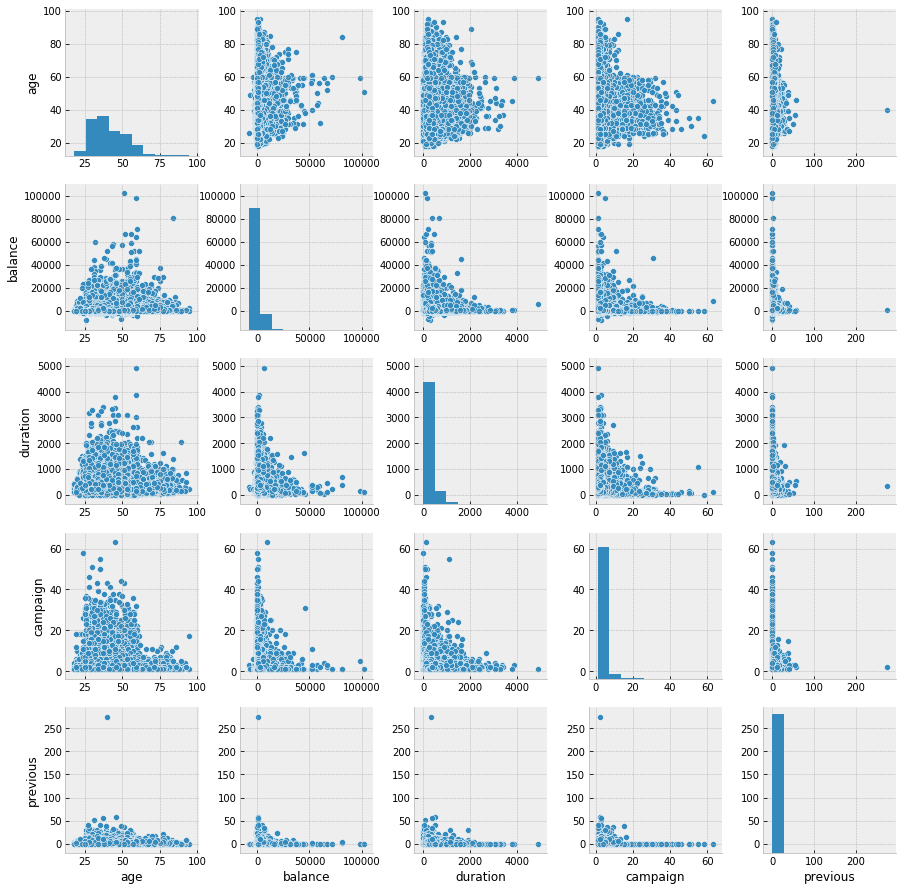

In [14]:
# Since I've just written a novel on the subject of very very basic EDA
# on this dataset, I'm going to try and speed along. I've covered or
# alluded to a few issues which I expect to be important later on.
# EDA takes time and it always pays to know your dataset well.

# Since we've examined value counts for all our categorical variables,
# I'll consider the EDA on those values by themselves concluded. Now 
# lets do some more analysis of the numeric columns. We'll look at how
# each column is distributed and how each relates to eachother, using
# Seaborn's 'pairplot' tool:

_ = sns.pairplot(data, vars = ['age','balance','duration','campaign','previous'])
# Uses every numeric column by default, but I excluded the column with NAs for now.


In [15]:
# Mean and median age among individuals who did and did not subscribe to a term deposit:

# We can simply take our dataset and group by the outcome variable 'y', then identify
# the single column we are interested in (age) and supply a function to do the
# within-group aggregation by:
data.groupby(by='y')['age'].mean()
# Those who did subscribe to the term deposit were on average almost
# a year older. That doesn't seem like a lot.

y
False    40.838986
True     41.670070
Name: age, dtype: float64

In [16]:
data.groupby(by='y')['age'].median()
# The median non-subscriber was a year older than the median subscriber!
# Mean and median are telling us two different things about the relationship
# between age and term deposit subscription. Among non-subscribers, the
# median was higher than the mean. Among subscribers, the mean was higher
# than the median.

y
False    39
True     38
Name: age, dtype: int64

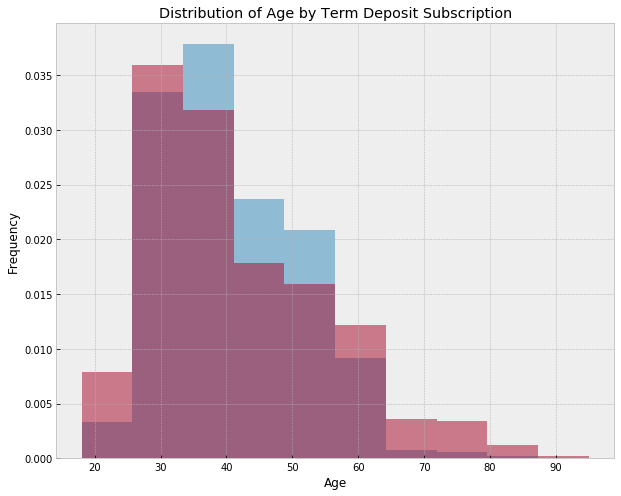

In [17]:
# Luckily, we can visualize this relationship:
_ = data.groupby(by='y')['age'].plot(kind='hist', normed=True, alpha=.5)
_ = plt.title('Distribution of Age by Term Deposit Subscription')
_ = plt.xlabel('Age')
# I'm grouping by subscription status and plotting the ages for each group,
# normalizing to account for the increased number of non-subscribers. And I'm
# setting alpha, the transparency parameter, to .5 so you can see both groups.

In [18]:
# We can test for whether the difference between these two means is actually significant:
print(stats.ttest_ind(data[data['y'] == True]['age'], data[data['y'] == False]['age']))

# With a p-value way above any sensible confidence level, we can reject the null
# hypothesis that the mean of subscribers and non-subscribers are actually different.
# I've assumed the variance among both populations are the same, which I think is 
# reasonable in this case.
# Simply put, it is very, very, very likely we would observe a difference of this
# magnitude between these two sample means simply by chance. Which I think we have.

Ttest_indResult(statistic=5.3502554230362032, pvalue=8.825643691922395e-08)


In [19]:
# Bootstrap Samples:

def bootstrap_sample(sample, n=100, replicate = False, size=100):
    ''' Generates bootstrap samples and bootstrap replicates. 
    Bootstrap sample size defaults to 100. 
    Returns bootstrap samples unless replicate function supplied.
    For use outside this DSIR exercise, size should default to the
    length of the sample.'''
        
    bootstraps = [list(np.random.choice(sample, size = size)) for i in range(n)]
    
    if replicate == False:
        return(bootstraps)
    else:
        return(list(map(replicate, bootstraps)))
        
# Some extras:
        
# def gen_bootstrap_conf_int(sample, n=100, statistic = np.mean, alpha= 5):
#     ''' Generates confidence interval of bootstrap statistic 
#     with confidence level given by 1 - alpha. Defaults to bootstrap mean.'''
        
#     replicates = bootstrap_sample(sample = sample, n = n, replicate = statistic, size = len(sample))
#     return(np.percentile(replicates, (alpha / 2 , 100 - (alpha / 2))))
      

# def plot_bootstrap(sample, alpha, statistic, n = 10000, plot_replicates = True, bins = 20):
#     ''' Plots distribution of bootstrap replicates or original sample with 
#     confidence interval at 1-alpha confidence level'''
    
#     conf_int = gen_bootstrap_conf_int(sample, n = n, statistic = statistic, alpha = alpha)
#     if plot_replicates == True:
#         plt.hist(bootstrap_sample(sample, replicate=statistic, n = n),bins = bins)
#         title_string = 'Distribution of Bootstrap Replicate '
#     else:
#         plt.hist(sample, bins = bins)
#         title_string = 'Data with Bootstrap Estimate of '
#     plt.axvline(np.mean(sample), color ='w', linestyle='--')
#     plt.axvline(conf_int[0], color = 'k', linestyle = '-')
#     plt.axvline(conf_int[1], color = 'k', linestyle = '-')
#     plt.title(title_string + statistic.__name__.capitalize() + '\nwith ' + str(100-alpha) + '% Confidence Interval')
    
#     plt.show()
    
# plot_bootstrap(data['age'], n=1000, plot_replicates = False, alpha = 5, statistic = np.median)

## Exploratory Analysis

Without doing any modeling, we can really only consider bivariate relationships,
(relationships between two variables), unless we want to get really fancy and
say that one variable predicts subscription to a term deposit *conditional on*,
for example, the customer being married, or male, or low-income, or whatever...

To begin with, we already have a pretty good idea that the age of subscribers
and non-subscribers is the same, so age won't be predictive *on its own*.

Lets group by outcome again and examine the differences between variables
conditional on the outcome we're interested in.

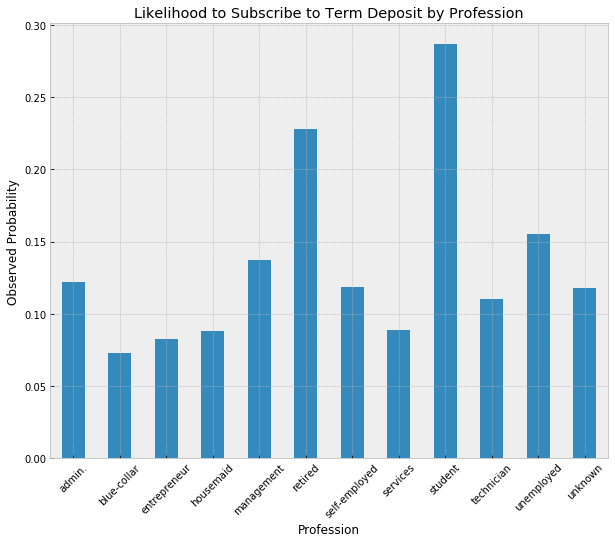

In [20]:
_ = data.groupby(by='y')['job'].value_counts()
# Right off the bat, we can see that term deposit subscribers are most commonly
# management, while non-subscribers are most commonly blue-collar. But we need to 
# account for the fact that blue-collar and management are each more common than the
# other professions.

_ = data.groupby('job')['y'].mean().plot(kind='bar')
_ = plt.xticks(rotation=45)
_ = plt.title('Likelihood to Subscribe to Term Deposit by Profession')
_ = plt.ylabel('Observed Probability')
_ = plt.xlabel('Profession')
# Now we've grouped by job, and we're looking at the probability that each job
# is a subscriber. (Remember we've encoded our output as boolean, which reduces
# to zeroes and ones.)
# While we can see that management does subscribe to term deposits at close to 
# two times the rate of blue-collar workers, they're not the most enthusiastic
# customers. Students are the most likely to subscribe to term deposits, followed
# by retired people! I imagine this is because they're both populations
# that want to invest some of their money in a low-risk way. Additionally,
# retired folks may have a range of other investments, while students may only
# use term deposits as a way of seeing some return on investment and forcing
# themselves not to spend what money they have. The unemployed are also likely
# to subscribe, perhaps for some of the same reasons.

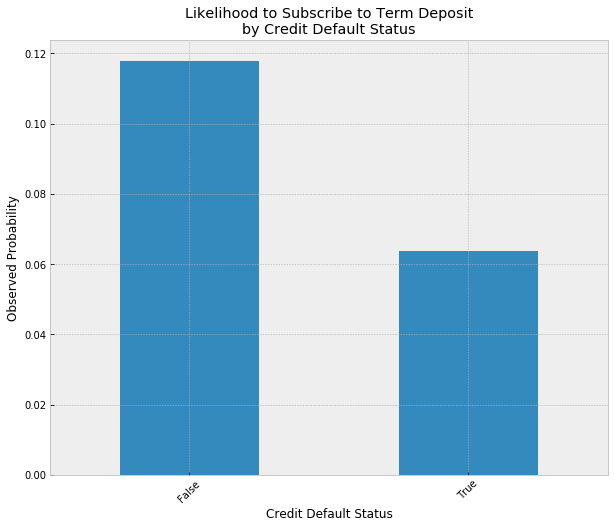

In [21]:
_ = data.groupby(by='default')['y'].mean().plot(kind='bar')
_ = plt.xticks(rotation=45)
_ = plt.title('Likelihood to Subscribe to Term Deposit\nby Credit Default Status')
_ = plt.ylabel('Observed Probability')
_ = plt.xlabel('Credit Default Status')
# People who don't have any credit in default are nearly twice as likely
# to subscribe to term deposits. This makes sense. Folks in financial
# difficulty aren't as likely to invest in a low-risk illiquid instrument,
# and they're less likely to be financially literare or responsible to begin with.

In [22]:
# _ = data.groupby(by='month', sort=False)['y'].mean().plot(kind='bar')

# When we group by month, we observe that people are much more likely to
# subscribe to term deposits if they were last contacted during certain months.
# There doesn't seem to be much of a seasonal trend, e.g. people subscribing
# if contacted during the holidays. Instead, campaigns during certain months
# were just more successful, or people are more receptive during certain
# months. Additionally, we should consider we don't actually have access
# to the information about *when* term deposit subscriptions were made.
# It could be that people just sign up in bigger numbers during these
# months, and therefore they aren't contacted during subsequent campaigns.

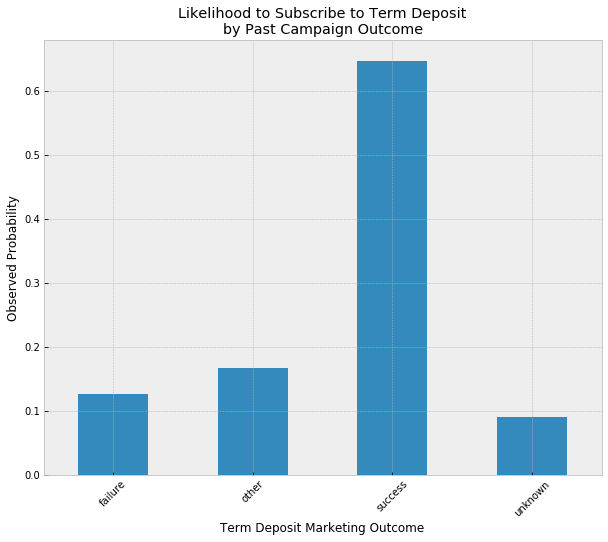

In [23]:
# Unsurprisingly, past subscription to a term deposit appears
# highly predictive of future subscription to a term deposit:
_ = data.groupby(by='poutcome')['y'].mean().plot(kind='bar')
_ = plt.xticks(rotation=45)
_ = plt.title('Likelihood to Subscribe to Term Deposit\nby Past Campaign Outcome')
_ = plt.ylabel('Observed Probability')
_ = plt.xlabel('Term Deposit Marketing Outcome')

In [24]:
# People with negative balances seem particularly unlikely to subscribe to a term deposit:
# _ = data.groupby(by='y')['balance'].plot(kind='hist', alpha=.5, bins=[-1000,0,1000,2000,3000,4000,5000,6000])
# _ = plt.title('Distribution of Account Balances\nby Subsription Status')
# _ = plt.xlabel('Account Balance, Euros')
# _ = plt.legend()

Ttest_indResult(statistic=9.9335453929622552, pvalue=4.3837327771001536e-23)


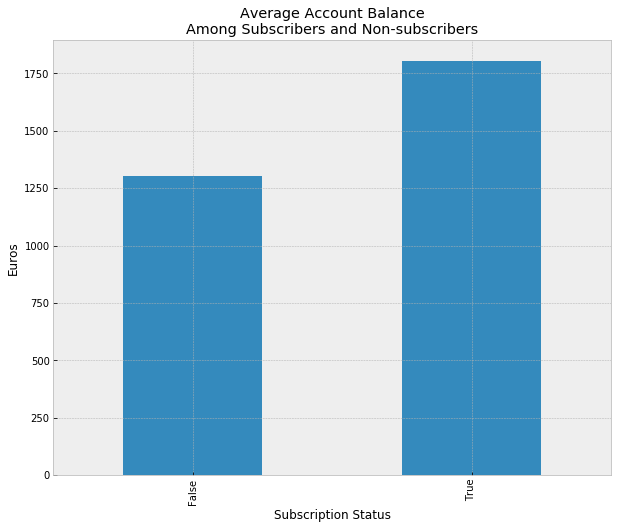

In [25]:
_ = data.groupby(by='y')['balance'].mean()
# Average account balance among term deposit subscribers is 500 Euros
# more than non-subscribers, and this difference is highly significant,
# even if we relax the assumption of equal variance between the two groups
# (Welch's T-test)
print(stats.ttest_ind(data[data['y'] == True]['balance'],
                      data[data['y'] == False]['balance'],
                      equal_var=False))

_ = data.groupby(by='y')['balance'].mean().plot(kind='bar')
_ = plt.title('Average Account Balance\nAmong Subscribers and Non-subscribers')
_ = plt.xlabel('Subscription Status')
_ = plt.ylabel('Euros')

In [26]:
# Ditto for duration of last marketing contact, in seconds. Those who subscribed
# were on the phone with a marketing person for twice as long the last time 
# they talked! No way this is a coincidence.
_ = data.groupby(by='y')['duration'].mean()
print(stats.ttest_ind(data[data['y'] == True]['duration'],
                      data[data['y'] == False]['duration'],
                      equal_var=False))

Ttest_indResult(statistic=57.514126544567887, pvalue=0.0)


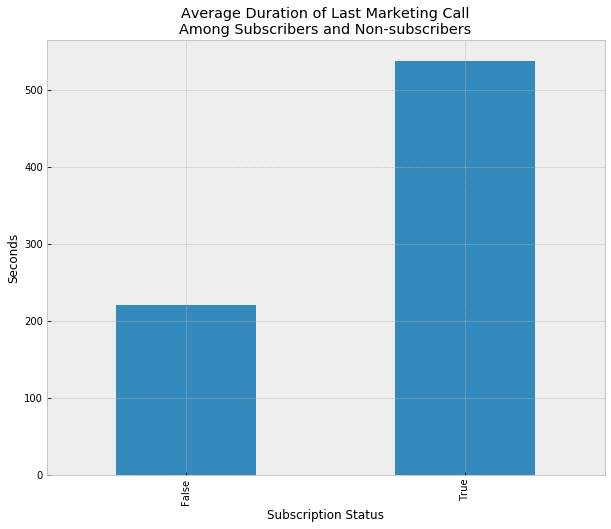

In [27]:
_ = data.groupby(by='y')['duration'].mean().plot(kind='bar')
_ = plt.title('Average Duration of Last Marketing Call\nAmong Subscribers and Non-subscribers')
_ = plt.xlabel('Subscription Status')
_ = plt.ylabel('Seconds')

## Modeling

#### Build a model to predict whether or not the client has subscribed a term deposit.

First, lets get our data ready to be modeled.
Recall that we had just one null value, corresponding to the number of days that 
have passed since the customer was contacted by marketing, given the customer was
*never* contated by marketing. There's no obvious way to fill 
this value, and it will largely depend on the modeling technique chosen. The actual maximum 
value for this variable was in 800's. Since a customer that has never been contacted
is like one that hasn't been contacted in a really long time, I chose to set
that value to 1000, but we could plan to revisit this decision later if we want
to see how we can further improve model performance.

This way of handling uncertainty is called 'sensitivity analysis': 
essentially we're seeing how our model performance is ultimately affected by all these
little choices we make along the way.

In [28]:
assert data.isnull().sum().sum() == 0 # Never hurts to check again for null values.

Recall we have some categorical variables. Some modeling techniques can in theory handle them
the way they are, but in practice they need to be represented as separate columns. Other methods
absolutely require categorical variables are encoded numerically as separate columns.

Based on our EDA, I'm going to drop some values of our categorical variables because I think
they're not very important. In the case of previous marketing campaign outcomes, it turns
out that 'success' looks predicive, but the other values, especially since they are 
'unknown' and 'other', don't differ much from 'failure.'

In [29]:
data['psuccess'] = [1 if x == 'success' else 0 for x in data['poutcome']]
data = pd.get_dummies(data, columns = ['job','marital','education'])

In [30]:
# When we construct dummy variables, we often need to drop one so some of our
# independent variables aren't perfectly dependent on one another. In this case, 
# lets drop the columns corresponding to 'unknown' values, and the column
# corresponding to being single, since that is the default marital status.
# We also drop 'poutcome,' since we dealt with it before.
data.drop(['education_unknown','job_unknown','marital_single','poutcome'], axis=1, inplace=True)

In [31]:
# I made a very conscious choice here to treat the good months as having
# something in common that the bad months do not, and to capture that difference
# in a single column. I will reserve the option later on to encode months 
# in different dummy columns, if I choose to.

data['good_month'] = [1 if x in ['oct','dec','mar','sep'] else 0 for x in data['month']]
data.drop('month', axis=1, inplace=True)

In [32]:
data.groupby(by='contact')['y'].mean()

# Lastly, I wanted to drop the 'contact' column, but it turns out that customers
# for whom we don't know the contact method were much less likely to subscribe,
# while people we know were contacted by any type of phone were more likely.
# I'll capture that difference in one column.

data['phone'] = [1 if x in ['cellular','telephone'] else 0 for x in data['contact']]
data.drop('contact', axis=1, inplace=True)

Now that our data is numeric, lets split it into training, validation, and
test sets. We do this instead of training our model on all of the data
so that we can ensure our model performs well on data it wasn't trained on.
We want to make sure that our model is picking out 'the signal' from 
'the noise.' If the model learns too many irrelvant features (noise) from
the training data, we say it is 'overfit' and unlikely to perform well
on future data.

Therefore, the training set will be used to fit our model, while the validation
set will be used to assess the performacne of our model by computing various
model performance metrics. Since we'll be checking our model performance
on the validation set, there's a chance we'll overfit our model to the validation
set, by 'over-optimizing' our model to perform well on it. Thus,
we hold on to a final test set that we only run our model on a few times
when we are done with our analysis.

Its important not to go back
and change little details after you've seen the performance on the test set,
although you might decide to go back to the drawing board if your test
set performance is poor. Additionally, you might use the test set to
determine which type of model is better, after we have optimized two
different models using the validation set.
The performance of our model on the test set is the final estimate of
how our model would perform on true out of sample data.

In [33]:
# First divide the independent variables from the dependent variable:
X = data.drop('y', axis=1)
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.4) # Using an initial split of 60/40
X_val, X_test, y_val, y_test     = train_test_split(X_test, y_test, test_size=.5) # Splitting the test set

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
# I like to print out the shapes of the X matrices to make sure I've done everything correctly.
# Here we have a nice 60/20/20 train/val/test split.

(27126, 29)
(9042, 29)
(9043, 29)


#### Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.

I'm going to try out a logistic regression first, since it is well known
and powerful technique. It also has the benefit of being very interpretable,
which is useful in our case for explaining what factors actually lead someone to
invest in a term deposit.

I've chosen to use Sci-kit Learn's implementation of Logistic Regression with
regularization and cross-validation. Regularization means we're artificially
penalizing large coefficient values so our model is less likely to estimate
large magnitude effects. It will help us to avoid overfitting
our model. The size of the penalty is usually determined by finding the size
that achieves the best model performance. A too-large penalty will make the 
model more 'wrong' on average, or biased, while a too-small penalty will
increase the variance of the model, or how sensitive the model is to different
training data. We want a model that is sensitive enough to the training data
to learn important patterns, but not so sensitive that it learns irrelevant
patterns.

Cross-validation occurs when a model is trained on a subset of the training data,
then evaluated on a held out set of the training data. A model is trained using
'k' unique hold out sets, so the method is called 'K-fold Cross-validation.'

In [34]:
logreg = LogisticRegressionCV(class_weight = 'balanced', penalty='l1', solver='liblinear', scoring = 'roc_auc')
logreg.fit(X_train,y_train)
logreg.score(X_val, y_val)

0.84074319840743195

In [35]:
predictions = pd.DataFrame({'preds':logreg.predict(X_val), 'probability':[x[1] for x in logreg.predict_proba(X_val)]})
predictions[predictions['preds'] == True].head(10)

,preds,probability
3,True,0.812599
6,True,0.949437
7,True,0.999929
8,True,0.808467
9,True,0.824121
11,True,0.592851
12,True,0.672622
14,True,0.847928
15,True,0.938604
20,True,0.909708


In [36]:
roc_auc_score(y_val, y_score = predictions['probability'])

0.90289475453743018

Without balancing our classes by over-weighting customers who did subscribe
and under-weighting those who did not, our model achieved 90% accuracy on
the validation set by just being very likely to classify people as likely
non-subscribers. After balancing our classes automatically (thanks to sklearn),
our accuracy drops to 84% but the area under the Receiver-Operating Curve
improves from .900 to .903.

(This is simply a measure of performance
that takes into account all possible rates of true positive and true negative
classification, regardless of the classification threshold of your model.
.5 is the worst you can do, and 1 is a perfect classifier.)


But an improvement of .003 is not a huge improvement to an already pretty
good ROC-AUC score. Should we balance our classes or not? How good is
our model? 

Most importantly:
How can we turn this model performance into something that a bank
manager would understand?

In [37]:
# Lets examine the confusion matrix for our model. It tells us the number
# of true positives, true negatives, false positives, and false negatives 
# in the set we're evaluating.

# In a confusion matrix C(0,0) is TN, C(1,0) is FN, C(1,1) is TN, C(0,1) is FP

CM = confusion_matrix(y_val, y_pred = logreg.predict(X_val))
print(CM)

[[6753 1231]
 [ 209  849]]


In [66]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
_ = TP / (TP + FN)

# False positives per true positive
_ = FP / TP

# # Precision, or positive predictive value
_ = TP / (TP + FP)

Using the model with balanced classes:
Of the 9,042 observations in the validation set, we are correctly classifying
849 people as term deposit subscribers but we're missing out on 209 of them.
Unfortunately we're also classifying 1123 people as term deposit subscribers
who actually aren't.
For our bank manager, we'd say that our model captures 78% of term deposit
subscribers but at the cost of classifying 1.3 non-subscribers as subscribers
for every single actual subscriber we classify. We would say, of the people
classified as subscribers, only 43% of them actually are subscribers.

(These percentages correspond to typical evaluation metrics: sensitivity
is the number of positive cases correctly classified as such, and precisionis the number of predicted positives that actually are positives.)

If we don't want to mess with our customers by targeting likely non-subscribers
with marketing calls, we might lower our classification threshold so we're
classifying fewer non-subscribers as subscribers. But then we would miss out
on classifying some of the true subscribers as such. Ultimately, it depends
on the costs associated with marketing calls and the discretion of the people
in charge at the bank.

In [40]:
# Lets define a quick function for classifying based on a classification threshold
# other than 50%. Once we've created a good model using (in this case) AUC-ROC
# scores, we want to provide predictions to our boss with whatever classification
# threshold she thinks produces the best predictions for the bank's needs.

def predict_with_threshold(probas, threshold):
    '''Returns predictions of the positive class using a given classification
    threshold. Assumes the positive class is the second (index 1).'''
    prob_positive = [x[1] for x in probas]
    preds         = [1 if x > threshold else 0 for x in prob_positive]
    return(preds)

In [41]:
# As an example, here's our confusion matrix with a classification threshold of 70%. 
# Now, more than half of our predictions correspond to true subscribers! But at the cost
# of now only capturing 64% of subscribers now.
CM = confusion_matrix(y_val, y_pred = predict_with_threshold(logreg.predict_proba(X_val), .7))
print(CM)

[[7363  621]
 [ 377  681]]


In [42]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
_ = TP / (TP + FN)

# False positives per true positive
_ = FP / TP

# # Precision, or positive predictive value
_ = TP / (TP + FP)

In [43]:
logreg_coefficients = pd.DataFrame({'Variable':X_train.columns,'Coefficients':logreg.coef_[0]})

These are the 5 most important variables according to our model. Logistic regression
is nice because it gives us interpretable coefficients for each variable. Normally, 
each coefficient corresponds to the effect of an additional unit of that variable
on the likelihood of a customer subscribing to a term deposit. In particular, 
we say that a 1 unit change in a variable means a customer is X times AS likely
to subscribe, where X is the coefficient. But since we are regularizing our
variables to avoid overfitting, that usual interpretation doesn't apply as nice.
If my boss wanted to know the *exact* relationships in the data, I would run
a non-regularized logistic regression. Since we're trying to predict subscribers,
we're using the regularized version of the model so our out-of-sample predictions
are more likely to be good.

Stil, we can still observe differences in effect even if we can't interpret
the coefficients in exactly the same way. We can see below that if the customer
previously subscribed, they are much more likely to subscribe
than if they didn't previously subscribe. Similarly, if last contact were in a 
good month, they are more likely to subscribe. Reaching people
by phone (compared to 'unknown' methods) is clearly best. And of course we see
that students and the retired are likelier to subscribe. Unsurprising based
on our EDA.

In [44]:
logreg_coefficients.sort_values(by='Coefficients', ascending=False).head(5)

,Coefficients,Variable
10,2.128700,psuccess
27,1.846428,good_month
28,1.297621,phone
19,0.721563,job_student
16,0.570818,job_retired


Here we look at factors that make someone unlikely to subscribe. Having
housing or personal loans means someone is unlikely to subscribe to a
term deposit. That makes sense since if they owe the bank already,
why would they choose to put away some of their money in a low
interest-rate illiquid investment?
We can see that those with only primary education are unlikely to 
subscribe, as are married folks and entrepreneurs.
It is important that each of these effects are *ceteris paribus*,
or the effect of this variable holding all other variables equal.

In [45]:
logreg_coefficients.sort_values(by='Coefficients', ascending=True).head(5)

,Coefficients,Variable
3,-0.763916,housing
4,-0.635793,loan
24,-0.413879,education_primary
23,-0.344077,marital_married
25,-0.228172,education_secondary


Lets try out another model and see how it does. Random Forest models
are very powerful and common models that are important to understand.
Essentially, the model creates a decision tree, or flow chart, that
dictates how to classify the observation according to different values
for each of our variables. The model then creates lots of these different
trees, varying them each slightly by allowing only certain variables
to 'count' at each division in the tree. This way, the majority vote
across all decision trees is better and less likely to be overfitted
than the prediction from a single tree. It's a wisdom of the crowds
approach, and intuitively we can understand that a bunch of individual 
decision trees which are randomly exposed to the data at each branch
will be less likely overall to learn irrelevant patterns than a single
tree training on all the features at every step.

In [46]:
forest = RandomForestClassifier()
forest.fit(X_train, y_train)
forest.score(X_val, y_val)

0.89769962397699621

In [47]:
predictions = pd.DataFrame({'preds':forest.predict(X_val), 'probability':[x[1] for x in forest.predict_proba(X_val)]})

roc_auc_score(y_val, y_score = predictions['probability'])

0.8704464103064351

So far our random forest model doesn't do as well as our logistic regression
on our chosen metric, the area under the ROC curve.
But random forests require a lot more decisions to be made when initializing
the model. These are called hyperparameters, and we can try out a range of them
to see which are best.

In [48]:
# Re-initialize the model with a few hyperparameters set.
forest = RandomForestClassifier(max_depth=150, max_features='auto', class_weight='balanced_subsample')

# Then create a grid of parameter values to try:
param_grid = {'n_estimators':[300,500]} #,'max_features':['auto',None], 'max_depth':[150, 200]}

Grid search will train a model with every possible combination of hyperparameters to see
which does best. It does this by evaluating the ROC-AUC score on the training data
using cross-validation, the same way that LogisticRegressionCV chose the size of
the penalty.

I've grid searched a few times to narrow down the list of best possible 
hyperparameters. Above, you can see I've commented out the 'max_depth' 
parameter because I already know a max depth of 150 is best for our data.
Grid searching will usually be incremental like this; you won't want to try
and search over *all* possible values of your hyperparamets. You'll break
your computer.

In [49]:
forest_grid = GridSearchCV(forest, param_grid=param_grid, scoring='roc_auc', n_jobs = -1)
forest_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=150, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [300, 500]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [50]:
# It turns out that using Sci-kit Learns default mode for feature subselection
# and 500 individual decision trees, plus artificially balanced classes,
# is about as good as we can get, plus 
# the hyperparameter values we already established by grid searching
# incrementally.
forest_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=150, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [51]:
forest = forest_grid.best_estimator_
forest.fit(X_train, y_train)
forest.score(X_val, y_val)

# When we train and evaluate the accuracy of our model using the best
# hyperparameters, we observe an accuracy score which beats our logistic regression.

0.90201282902012825

In [52]:
predictions = pd.DataFrame({'preds':forest.predict(X_val), 'probability':[x[1] for x in forest.predict_proba(X_val)]})
predictions[predictions['preds'] == True].head(10)

,preds,probability
3,True,0.620
6,True,0.622
7,True,0.584
8,True,0.564
14,True,0.710
93,True,0.558
94,True,0.722
111,True,0.702
112,True,0.606
121,True,0.588


In [53]:
# And the AUC-ROC score is better too! Just based on performance, the optimized
# random forest model does better than our logistic regression.

roc_auc_score(y_val, y_score = predictions['probability'])

0.9156658662315178

In [54]:
# We can do the same analysis for random forests that we did for the logistic regression,
# which is what we'll do in order to help decide which model is best:

CM = confusion_matrix(y_val, y_pred = forest.predict(X_val))
print(CM)

[[7825  159]
 [ 727  331]]


In [55]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
sens = TP / (TP + FN)

# False positives per true positive
fp_tp = FP / TP

# Precision, or positive predictive value
prec = TP / (TP + FP)

print(sens, fp_tp, prec)

0.312854442344 0.480362537764 0.675510204082


We're catching only 31% of subscribers, mis-categorizing 1 person as likely
to subscribe per 2 people we correctly classify,
and of the people we predict to subscribe,
68% actually will. Although this method is missing out on many actual subscribers,
we can be more confident that the customer it does identify as likely to subscribe
will actually do so.

In [56]:
# With a lower classification threshold, the model performs more closely to the
# logistic regression's default threshold of 50%.

CM = confusion_matrix(y_val, y_pred = predict_with_threshold(forest.predict_proba(X_val), .25))
print(CM)

[[7219  765]
 [ 284  774]]


In [57]:
TN = CM[0][0]
TP = CM[1][1]
FN = CM[1][0]
FP = CM[0][1]

# Sensitivity, or true positive rate
sens = TP / (TP + FN)

# False positives per true positive
fp_tp = FP / TP

# Precision, or positive predictive value
prec = TP / (TP + FP)

print(sens, fp_tp, prec)

0.73156899811 0.988372093023 0.502923976608


Because each model can be adjusted to suit my boss at the bank's purposes,
I like the area under the ROC curve as a final arbiter of which model is better:
The value is the same for any threshold value.

So now its time to break out that test set and make our final decision:

In [58]:
test_predictions = pd.DataFrame({'y_true':y_test,
                                 'LR_prob':[x[1] for x in logreg.predict_proba(X_test)],
                                 'Forest_prob':[x[1] for x in forest.predict_proba(X_test)]})
# Visually inspecting the results of each model we can see that the random forest model
# is more likely to classify customers as non-subscribers.

In [59]:
print('Logistic Regression Score on Test Set:' + str(roc_auc_score(y_test, y_score = test_predictions['LR_prob'])))
print('Random Forest Score on Test Set:' + str(roc_auc_score(y_test, y_score = test_predictions['Forest_prob'])))

Logistic Regression Score on Test Set:0.902326526346
Random Forest Score on Test Set:0.911716776678


Sure enough, our random forest model does better on that final held out test set,
so our best guess is that it would do better on completely new, unseen data. If we 
just want to predict subscription to term deposits, and we don't want to understand
why people do or do not subscribe, we can stop here. But since our model performances
were so similar, we may consider presenting the logistic regression to our boss since
it does a better job of explaining the phenomenon.

In [60]:
# To understand the effect of different features in a random forest model, we have to 
# compute feature importances:
Forest_Importances = pd.DataFrame({'Variables':X_train.columns,'Importances':forest.feature_importances_})
Forest_Importances.sort_values(by='Importances', ascending=False).head()

,Importances,Variables
6,0.374562,duration
2,0.096365,balance
0,0.085469,age
5,0.074597,day
8,0.045231,pdays


These are the most important 5 features, in that they contribute to decisions 
within the random forest model the most. But we can't interpret them as having
an effect in one way or another, or ceteris paribus for that matter. Each
variable might have a certain effect some of the time and another effect the
rest of the time. For example, if someone is a student a high account balance might
mean they subscribe to a term deposit, while if someone is an entrepreneur 
the oppposite relationship might hold.

In [61]:
Forest_Importances.sort_values(by='Importances', ascending=True).head()

,Importances,Variables
1,0.001514,default
14,0.003025,job_housemaid
13,0.003589,job_entrepreneur
17,0.004005,job_self-employed
21,0.004042,job_unemployed


These are the least important 5 features. Again, we can't say much about
them, except that they tend not to contribute much to decisions. It is
surprising to see 'default' status not mattering much, but we unfortunately
can't really get to the 'why' of that fact within some serious digging.
We might think about dropping out these variables if we were super concerned
about model complexity, though.

In [62]:
# As a final presentation to my boss: this is how I might summarize my model
# performance:

Final_Model_Performance = pd.DataFrame(columns = ['Threshold','True Positive Rate',
                                        'False Positives Per True Positive'])


In [63]:
for threshold in range(10,95,5):
    CM = confusion_matrix(y_test, y_pred = predict_with_threshold(forest.predict_proba(X_test), threshold/100))

    TP = CM[1][1]
    FN = CM[1][0]
    FP = CM[0][1]

    sens = TP / (TP + FN)
    try:
        fp_tp = FP / TP
    except:
        fp_tp = 0
    Final_Model_Performance.loc[Final_Model_Performance.shape[0]] = [threshold, sens, fp_tp] 
    

In [64]:
Final_Model_Performance = Final_Model_Performance.set_index('Threshold')

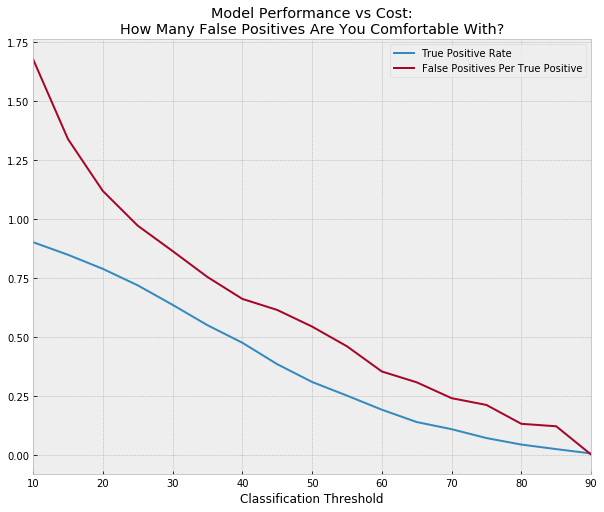

In [65]:
_ = Final_Model_Performance.plot()
_ = plt.title('Model Performance vs Cost:\nHow Many False Positives Are You Comfortable With?')
_ = plt.xlabel('Classification Threshold')

## Explanation

To Technical Audiences

Explain the limitations of your analysis and identify possible further steps you could take.

To Non-Technical Audiences

Write a short summary of your analysis, explaining how your model works and how it performs.

Briefly explain the factors that contributed to identifying subscription versus non-subscription.

### To Technical Audiences:

In the EDA and data preparation phase, I made a number of conscious choices about how to treat null values and categorical variables. Further analysis could be conducted on the impact of those choices. In particular, I chose not to do much using the granularity of the time data provided to me. If I wanted to assess the impact of time, I could engineer features corresponding to whether the last campaign contact was on the weekend or during the business day, for example.

I use a linear model to predict subscription to term deposits, but I don't take advantage of any of the statistical tests that are available to test the significance of my results. In further analysis, I would run the same logistic regression model using the `statsmodels` package in order to get p-values on each of my coefficients. That way, I could confidently assess whether certain effects were likely 'real' or by chance.

Since the random forest model proved better, I would try and build on it by seeing how more advanced tree-based methods performed. Boosting aglorithms such as XGBoost could be used to improve model performance even further.

### To Non-Technical Audiences

I analyzed a dataset of bank customers giving information on their age, profession, bank details, and how much they were contacted by bank marketing. The goal was to explain why they subscribed to term deposits (or didn't), and to predict whether future customers would or would not subscribe to term deposits.

I used two different models to do this, and saw very good results with each of them. Each model was able to identify likely subscribers well, even though there were relatively few of them in the dataset. The models could both be adjusted to be more or less good at detecting the customers who would likely subscribe, at the cost of classifying some non-subscribers as subscribers. Therefore the ultimate classification from the model must suit business needs.

The model that I recommend for predicting customer subscription is called a random forest model. Predictions are made by majority vote among a lot of individually simpler models called decision trees. Each decision tree works like a flow chart where a series of questions are asked about the data based on the variables available. Each decision tree is randomized by 'hiding' some of the data from them. That way, the majority vote of all decision trees gives us a pretty good estimate without being too specific to just the data we trained the model on.

In order to explain the importance of different factors, I utilize another model which was only slightly less powerful. It tells, for a certain change in each variable, how much more or less likely a customer is to subscribe to a term deposit. The best predictor of subscription was, unsurprisingly, subscription to a term deposit during the bank's previous marketing campaign. Additionally, reaching people by phone and at certain times of the year is highly effective. Retired people and students are most likely to subscribe to a term deposit, all else being equal. Meanwhile people with loans from the bank, those with only primary education, married folks, and entrepreneurs are relatively less likely to subscribe.

# Part II

I was too exhaustive and verbose in Part I. But student feedback doesn't
benefit from being too exhaustive. Instead, it should focus on a few key
areas that need improvement, and avoid pointing out every single thing that
could be improved.
I'll provide feedback all at once, in the same way we're given feedback
for our labs (via Garnet), rather than via inline comments.

## Student Submission 1:

In [ ]:
from sklearn.cross_validation import cross_val_score

#!/usr/bin/env python

import pandas as pd
import numpy as np
from sklearn import LinearRegression
from sklearn.cross_validation import cross_val_score


# Load data
d = pd.read_csv('../data/train.csv')


# Setup data for prediction
x1 = data.SalaryNormalized
x2 = pd.get_dummies(data.ContractType)


# Setup model
model = LinearRegression()

# Evaluate model
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
scores = cross_val_score(model, x2, x1, cv=1, scoring='mean_absolute_error')
print(scores.mean())

- Be sure to run your notebook from top to bottom to make sure everything works before submitting. There are some avoidable errors in your code, such as forgetting to import LinearRegression from the linear_model module of Sci-kit Learn.
- It looks like you have a good grasp of order of operations for doing modeling, but you've skipped a few steps in your final submission. You've renamed your main dataframe from 'd' to 'data' but haven't included the code for doing so in your submission, for example.
- Make sure you include any EDA you've done! Its clear from your code you're dealing with 'ContractType' as a categorical variable, but you haven't shown how you examined that variable or the others.
- Smart move making dummy variables for 'ContractType.' Don't forget to drop one of them if you want to use a linear model, though. (Hint: remember the assumptions of the linear model.)
- You imported train_test_split but didn't end up creating training or test sets. Justify your decision not to use a train/test split. (Hint: are you trying to explain your dependent variable, or predict it? Are you worried about overfitting?)
- Great work setting up the cross validation scores and choosing a scoring method. But remember what the 'cv' parameter does. What happens when you set it equal to 1?

## Student Submission 2

In [ ]:
#!/usr/bin/env python

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

# Load data
data = pd.read_csv('../data/train.csv')


# Setup data for prediction
y = data.SalaryNormalized
X = pd.get_dummies(data.ContractType)

# Setup model
model = LinearRegression()

# Evaluate model
scores = cross_val_score(model, X, y, cv=5, scoring='mean_absolute_error')
print(scores.mean())

- Remember that you should spend a lot of time doing EDA and getting familiar with your data before you begin modeling. Display anything you may have learned about the dataset using descriptive statistics and visualizations.
- Smart move making dummy variables for 'ContractType.' Don't forget to drop one of them if you want to use a linear model, though. (Hint: remember the assumptions of the linear model.)
- It looks like you are only using one predictor variable. Are there more variables in the dataset? Its not clear from looking at your code what is included in `train.csv`, and if you've decided not to use some of the variables. Is there a `test.csv`?
- Excellent work deploying cross-validation to check average mean absolute error. MAE is a specific way to measure the performance of your model. You may want to justify your decision to use MAE instead of MSE or R-squared.